In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import numpy as np
import matplotlib.pyplot as plt
import torchvision, torch, glob
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Subset
from sklearn.model_selection import train_test_split
from sam.sam import SAM

# Dataset

In [2]:
transform_dict = {
        'train': transforms.Compose(
            [transforms.CenterCrop(256),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             ]),
        'test': transforms.Compose(
            [transforms.CenterCrop(256),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             ])}

data_folder = "./dataset2"

In [3]:
data = torchvision.datasets.ImageFolder(root=data_folder, transform=transform_dict['train'])

In [4]:
train_size = int(len(data) * 10 / 11)
valid_size  = len(data) - train_size      
data_size  = {"train":train_size, "valid":valid_size}
print(data_size)
data_train, data_valid = torch.utils.data.random_split(data, [train_size, valid_size])

{'train': 1020, 'valid': 102}


In [5]:
batch_size = 17
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
valid_loader   = torch.utils.data.DataLoader(data_valid, batch_size=1, shuffle=False)
dataloaders  = {"train":train_loader, "valid":valid_loader}

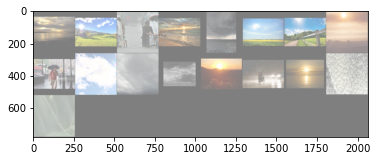

tensor(4) tensor(3) tensor(2) tensor(4) tensor(1) tensor(3) tensor(3) tensor(4) tensor(2) tensor(3) tensor(1) tensor(1) tensor(4) tensor(2) tensor(4) tensor(2) tensor(2)


In [6]:
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 訓練データをランダムに取得
dataiter = iter(dataloaders["train"])
images, labels = dataiter.next()

# 画像,ラベルの表示
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j] for j in range(17)))

#1:cloudy, 2:rain, 3:shine, 4:sunrise

# Learning

In [7]:
class AttentionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size =2), nn.LeakyReLU(),
            nn.Conv2d(in_channels = 8, out_channels = 32, kernel_size =2), nn.LeakyReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size =2), nn.LeakyReLU(), 
        )
        self.attn_conv = nn.Sequential(
            nn.Conv2d(64, 3, 1),
            nn.Sigmoid()
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(192,5), nn.Softmax(dim=1),
        )
    def forward(self, img):
        x1 = self.conv(img)
        attn = self.attn_conv(x1)
        B, A, H, W = attn.shape
        
        attn = attn.reshape(B,A,1,H,W)
        x1 = x1.reshape(B,1,64,H,W)
        x2 = x1 * attn
        x2 = x2.reshape(B*A, 64, H, W)
        
        x3 = F.adaptive_avg_pool2d(x2, (1,1))
        print(x3.reshape)
        x4 = x3.reshape(B,-1)
        print(x4.shape)
        x5 = self.fc(x4)
        print(x5.shape)
        return x5

In [8]:
epoch = 20
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = AttentionCNN()
model.to(device)

loss_func = nn.CrossEntropyLoss()

#SAM
base_optimizer = torch.optim.SGD 
optimizer = SAM(model.parameters(), base_optimizer, lr=0.1, momentum=0.9)

In [9]:
train_loss_list = []
valid_loss_list = []
for i in range(epoch):
    train_running_loss = 0.0
    valid_running_loss = 0.0
    for images, labels in dataloaders["train"]:
        images = images.to(device)
        labels = torch.nn.functional.one_hot(labels, num_classes=5)
        labels = labels.to(device).to(torch.float32)
        
        outputs = model(images)
        
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.first_step(zero_grad=True)
        
        loss_func(model(images),labels).backward()  
        optimizer.second_step(zero_grad=True)
        
        train_running_loss += loss.item()
    if i % (epoch/10) == 0:
        score = 0
        for images, labels in dataloaders["valid"]:
            images = images.to(device)
            labels = torch.nn.functional.one_hot(labels, num_classes=5)
            labels = labels.to(device).to(torch.float32)
            
            outputs = model(images)
            loss = loss_func(outputs, labels)
    
            valid_running_loss += loss.item()
            
            label = torch.argmax(labels[0])
            output = torch.argmax(outputs[0])
            if label == output :
                score += 1
        
        train_running_loss /= 102
        valid_running_loss /= 173.4
        train_loss_list.append(train_running_loss)
        valid_loss_list.append(valid_running_loss)
        print("Epoch:{}, Train_Loss:{}, Valid_Loss:{}".format(i, train_running_loss, valid_running_loss))
        print("Acc:",score/102)
        
plt.yscale('log')
plt.plot(np.arange(len(train_loss_list)), train_loss_list, label="train")
plt.plot(np.arange(len(valid_loss_list)), valid_loss_list, label="valid")

<built-in method reshape of Tensor object at 0x00000182CD17B0E0>
torch.Size([17, 192])
torch.Size([17, 5])


RuntimeError: CUDA out of memory. Tried to allocate 798.00 MiB (GPU 0; 4.00 GiB total capacity; 2.43 GiB already allocated; 0 bytes free; 2.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#Prediction

In [ ]:
score = 0
i = 0
Total = 102
for images, labels in dataloaders["valid"]:
            i += 1
            image = images.to(device)
            label = F.one_hot(labels, num_classes=5)
            label = label.to(device).to(torch.float32)
            
            output = model(image)
            Label = torch.argmax(label[0])
            Output = torch.argmax(output[0])
            if Label == Output :
                score += 1
            else:
                print("Valid:", label[0])
                print("Predict:",output[0])
print("Acc:", score/Total)

# こだわりポイント
・SAMっていうoptimizer使った.めっちゃSoTA更新しているらしい!理論説明は頼んだ！ OK  
・attention使った。オリジナルで作ったからあんまりうまく行ってないかも。理解できたらViTransformer試したみたい....